In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload


import matplotlib.pyplot as plt
from scipy import signal
import pickle
import numpy as np
from scipy.spatial.distance import euclidean
from softmax import *
from misc import *


In [2]:
names = ["bike", "stand", "stairsup", "stairsdown", "sit", "walk"] 
signals = []
for i, name in enumerate(names): 
    print("data/maxvar_"+name)
    with open("data/maxvar_"+name, 'rb') as f:
        signals.append(pickle.load(f))

data/maxvar_bike
data/maxvar_stand
data/maxvar_stairsup
data/maxvar_stairsdown
data/maxvar_sit
data/maxvar_walk


In [3]:
support, px = signal.periodogram(signals[0][0], nfft=1000)
#support1, px1 = signal.periodogram((signals[0][0]), nfft=1000)

N = len(px)
nn = np.sum([len(s) for s in signals])

X = np.zeros((nn, N))
X1 = np.zeros((nn, N))
y = []

idx = 0
for i in range(len(signals)):
    y.extend([i for s in signals[i]])
    for j in range(len(signals[i])):
        _, X[idx, :] = signal.periodogram(signals[i][j], nfft=1000)
        X[idx] += 1e-6
        X[idx,:] /= np.sum(X[idx,:])
        idx += 1

# shuffle it
y = np.array(y)
np.random.seed(123)
idx = np.arange(len(y))
np.random.shuffle(idx)
X = X[idx, :]
y = y[idx]
y = y.reshape(-1,)
np.save('X', X)
np.save('y', y)

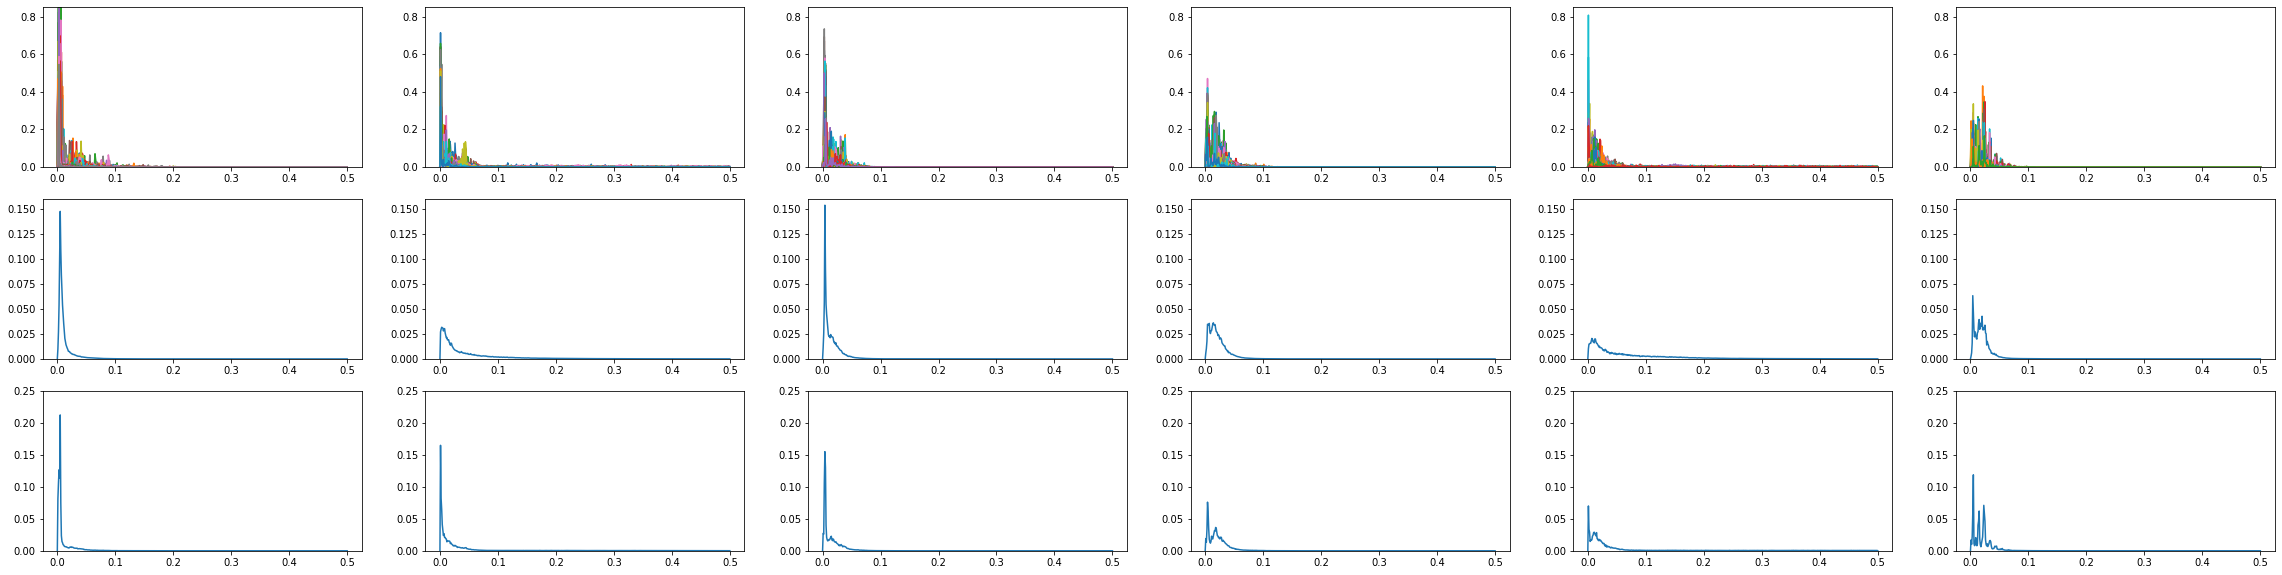

In [5]:
options_q = {'q_support': 1000}
quadratic=False
D = len(names)
fig, ax = plt.subplots(3,D, figsize=(40,10))

for i in range(D):
    ax[0,i].set_ylim([0,0.85])
    ax[0,i].plot(support, X[y==i].T)

    method = 'quantile'
    model_q = WSoftmax(X, y, support, distance=method, options=options_q, quadratic=quadratic)
    ax[1,i].set_ylim([0,0.16])
    ax[1,i].plot(support, model_q.bars[i,:])

    method = 'euclidean'
    model_q = WSoftmax(X, y, support, distance=method, options=options_q, quadratic=quadratic)
    ax[2,i].set_ylim([0,0.25])
    ax[2,i].plot(support, model_q.bars[i,:])


In [6]:
from scipy.spatial.distance import euclidean
from scipy.optimize import minimize

options_q = {'q_support': 1000}
q = False
nseeds= 100
n_class = len(names)
seeds = np.arange(nseeds)
scores = np.zeros((4,nseeds))
if q:
    x0=np.ones((2*n_class+1)*n_class)
else:
    x0=np.ones((n_class+1)*n_class)

for s in seeds:
    X_tr, X_te, y_tr, y_te = random_split(X, y, 0.8, seed=s)
    y_tr = y_tr.reshape(-1,)
        
    model_sink = WSoftmax(X_tr, y_tr, support, distance='KL', quadratic=q, robust=q)
    res = minimize(fun=model_sink.logp, x0=x0, jac=model_sink.dlogp, method='L-BFGS-B')
    theta = res['x']
    prob, pred = model_sink.pred(X_te, theta)
    scores[0,s] = np.sum(pred.reshape(y_te.shape) == y_te) / len(y_te)
        
    model_euc = WSoftmax(X_tr, y_tr, support, distance='euclidean', quadratic=q, robust=q)
    res = minimize(fun=model_euc.logp, x0=x0, jac=model_euc.dlogp, method='L-BFGS-B')
    theta = res['x']
    prob, pred = model_euc.pred(X_te, theta)
    scores[1,s] = np.sum(pred.reshape(y_te.shape) == y_te) / len(y_te)
    
    model_q = WSoftmax(X_tr, y_tr, support, distance='quantile', options=options_q, quadratic=q, robust=True, wass_square=False)
    res = minimize(fun=model_q.logp, x0=x0, jac=model_q.dlogp, method='L-BFGS-B')
    theta = res['x']
    prob, pred = model_q.pred(X_te, theta)
    scores[2,s] = np.sum(pred.reshape(y_te.shape) == y_te) / len(y_te)
    
    print('euclidean : {:5.4f} -- wasserstein : {:5.cd ..4f}'.format(scores[1,s],scores[2,s])) 

    #model_q = WSoftmax(X_tr, y_tr, support, distance='quantile', options=options_q, quadratic=True, robust=True, wass_square=False)
    #res = minimize(fun=model_q.logp, x0=x0, jac=model_q.dlogp, method='L-BFGS-B')
    #theta = res['x']
    #prob, pred = model_q.pred(X_te, theta)
    #scores[3,s] = np.sum(pred.reshape(y_te.shape) == y_te) / len(y_te)
    

ValueError: Format specifier missing precision

In [ ]:
plt.boxplot([scores[0,:], scores[1,:], scores[2,:]])
plt.show()


print(scores.shape)

m = 1
n = len(scores[m,:])
mean = np.mean(scores[m,:])
std =  np.sqrt(np.sum((scores[m,:] - mean)**2)/(n-1))
stderr = std / np.sqrt(n)
print(n)
print(mean)
print(stderr)
print(n)




In [ ]:
from scipy.spatial.distance import euclidean
from scipy.optimize import minimize

options_q = {'q_support': 1000}
q_supports = [80,90,100,150,200,250,300,1000]
q = False
nseeds= 20
n_class = len(names)
seeds = np.arange(nseeds)
scores = np.zeros((len(q_supports),nseeds))
x0=np.ones((n_class+1)*n_class)


for idx, q_s in enumerate(q_supports):
    options_q['q_support'] = q_s
    
    for s in seeds:

        X_tr, X_te, y_tr, y_te = random_split(X, y, 0.8, seed=s)
        y_tr = y_tr.reshape(-1,)
        
    
        model_q = WSoftmax(X_tr, y_tr, support, distance='quantile', options=options_q, robust=True)
        res = minimize(fun=model_q.logp, x0=x0, jac=model_q.dlogp, method='L-BFGS-B')
        theta = res['x']
        prob, pred = model_q.pred(X_te, theta)
        scores[idx,s] = np.sum(pred.reshape(y_te.shape) == y_te) / len(y_te)
        print(scores[idx,s])
    
    print('****************') 
    print(np.mean(scores[idx,:]))
    print('****************') 

In [16]:
from knn import *

nseeds= 10
n_class = len(names)
seeds = np.arange(nseeds)
methods = ['quantile', 'euclidean', 'KL']
scores = np.zeros((nseeds, len(methods)))

for s in seeds:
    for m_idx, m in enumerate(methods):
        X_tr, X_te, y_tr, y_te = random_split(X, y, 0.8, seed=s)
        y_tr = y_tr.reshape(-1,)
        
        n_te, D = X_te.shape
        results = np.zeros(n_te)
        for i in range(n_te):
            idx_neighbors = getNeighbors(X_tr, X_te[i, :], 6, m, support)
            result = getResponse(y_tr[idx_neighbors])
            results[i] = result
        scores[s, m_idx] = np.sum(results.reshape(y_te.shape) == y_te) / len(y_te)

In [17]:
print(np.mean(scores), np.std(scores)/np.sqrt(nseeds))

0.7489247311827959 0.009654617701623638


In [12]:
scores

array([0.])

In [19]:
print(np.mean(scores, axis=0))
print(np.std(scores, axis=0) / np.sqrt(nseeds))

[0.72580645 0.74354839 0.77741935]
[0.00441712 0.0071041  0.00849267]
